In [4]:
#Import libraries
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras import utils 
from keras import backend as K
import tensorflow.keras as K
from sklearn.utils import shuffle
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.layers import Dense, Activation, Dropout, Reshape, Permute, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

In [5]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define constants
PATH = os.getcwd()
data_path = 'Dataset'
img_rows = 224
img_cols = 224
num_channel = 3
num_epoch = 90
num_classes = 5

# Initialize lists to store image data
img_data_list = []

# Function to preprocess and load images
def preprocess_images(data_path, img_rows, img_cols):
    """
    Preprocess images by resizing and converting to grayscale.
    
    Args:
        data_path (str): Path to the dataset directory.
        img_rows (int): Height of the resized images.
        img_cols (int): Width of the resized images.
    
    Returns:
        np.array: Array containing preprocessed image data.
    """
    try:
        data_dir_list = os.listdir(data_path)
        for dataset in data_dir_list:
            logger.info(f"Processing dataset: {dataset}")
            excluded_files = [".DS_Store", ".Trashes"]
            if dataset in excluded_files:
                continue  # Skip hidden files

            img_list = [img for img in os.listdir(os.path.join(data_path, dataset)) if img not in excluded_files]
            logger.info(f"Loaded {len(img_list)} images from dataset: {dataset}")
            
            for img in img_list:
                img_path = os.path.join(data_path, dataset, img)
                input_img = cv2.imread(img_path)
                if input_img is not None:
                    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                    input_img_resize = cv2.resize(input_img, (img_rows, img_cols))
                    img_data_list.append(input_img_resize)
                else:
                    logger.warning(f"Failed to load image: {img_path}")

    except Exception as e:
        logger.error(f"Error occurred during image preprocessing: {str(e)}")

    return np.array(img_data_list)

# Preprocess and load images
img_data = preprocess_images(data_path, img_rows, img_cols)

# Check if img_data is empty
if len(img_data) == 0:
    logger.error("No images loaded. Exiting.")
    exit()

# Normalize image data
img_data = img_data.astype('float32') / 255.0

# Adjust image data format
if num_channel == 3:
    if img_data.shape[-1] != num_channel:
        img_data = np.expand_dims(img_data, axis=-1)
else:
    if img_data.shape[-1] != num_channel:
        logger.error("Invalid number of image channels.")
        exit()

logger.info(f"Preprocessed image data shape: {img_data.shape}")


INFO:__main__:Processing dataset: Avocado
INFO:__main__:Loaded 1001 images from dataset: Avocado
INFO:__main__:Processing dataset: .DS_Store
INFO:__main__:Processing dataset: Guava
INFO:__main__:Loaded 1001 images from dataset: Guava
INFO:__main__:Processing dataset: Mango
INFO:__main__:Loaded 1001 images from dataset: Mango
INFO:__main__:Processing dataset: African_Almond
INFO:__main__:Loaded 1001 images from dataset: African_Almond
INFO:__main__:Processing dataset: Cashew
INFO:__main__:Loaded 1001 images from dataset: Cashew
INFO:__main__:Preprocessed image data shape: (5000, 224, 224, 1)


X_train shape = (4000, 224, 224, 1)
X_test shape = (1000, 224, 224, 1)


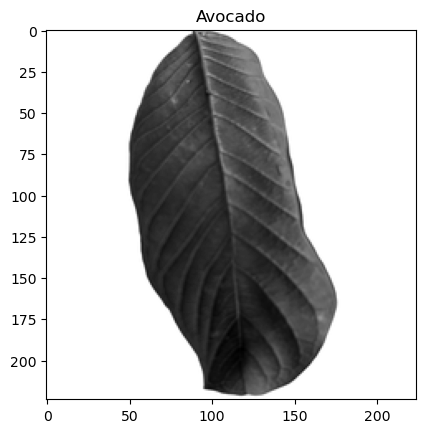

In [6]:
# Importing libraries
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Define the number of classes
num_classes = 5
names = ['African_Almond', 'Avocado', 'Cashew', 'Guava', 'Mango']

# Assign labels to the images
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1000] = 0
labels[1000:2000] = 1
labels[2000:3000] = 2
labels[3000:4000] = 3
labels[4000:5000] = 4

# Convert class labels to one-hot encoding
Y = to_categorical(labels, num_classes)

# Shuffle and split the dataset while maintaining the test size for each class
x_by_class = defaultdict(list)
y_by_class = defaultdict(list)

for i, label in enumerate(Y):
    x_by_class[np.argmax(label)].append(img_data[i])
    y_by_class[np.argmax(label)].append(label)

X_train, X_test, y_train, y_test = [], [], [], []

for class_index in range(num_classes):
    x_class = x_by_class[class_index]
    y_class = y_by_class[class_index]
    
    try:
        x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(
            x_class, y_class, test_size=200 / len(x_class), random_state=2
        )
        X_train.extend(x_train_class)
        X_test.extend(x_test_class)
        y_train.extend(y_train_class)
        y_test.extend(y_test_class)
    except ValueError:
        print(f"Skipping class {class_index}: Not enough samples for testing.")

# Convert lists to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train, random_state=2)

# Log shapes of training and test sets
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)

# Visualize a sample image from the training set
plt.imshow(X_train[36].reshape((224, 224)), cmap='gray')
plt.title(names[np.argmax(y_train[36])])
plt.show()


In [7]:
# Importing libraries
import numpy as np
import time
from collections import defaultdict
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define constants
num_classes = 5
batch_size = 32
epochs = 10

# Define the CNN model
model = Sequential([
    Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=X_train.shape[1:]),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    Activation('elu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(256, kernel_initializer='he_normal'),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, kernel_initializer='he_normal'),
    Activation('elu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, kernel_initializer='he_normal'),
    Activation('softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

# Display model summary
model.summary()

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

# Evaluate the model
start_time = time.time()
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
end_time = time.time()

# Calculate testing time
testing_time = end_time - start_time
print("Testing Time: {:.2f} seconds".format(testing_time))

# Save the trained model
model.save('model_keras_leaf_2.h5')

# Print test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy * 100)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/Users/muhammadyekini/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             

 Total params: 6,590,021 (25.14 MB)

 Trainable params: 6,588,517 (25.13 MB)

 Non-trainable params: 1,504 (5.88 KB)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 686ms/step - accuracy: 0.4752 - loss: 1.6142 - val_accuracy: 0.3120 - val_loss: 3.0778
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 667ms/step - accuracy: 0.6342 - loss: 1.0360 - val_accuracy: 0.3380 - val_loss: 2.9781
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 730ms/step - accuracy: 0.7095 - loss: 0.8000 - val_accuracy: 0.4230 - val_loss: 2.6882
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 654ms/step - accuracy: 0.7633 - loss: 0.6535 - val_accuracy: 0.5030 - val_loss: 1.9317
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 683ms/step - accuracy: 0.7881 - loss: 0.5718 - val_accuracy: 0.5940 - val_loss: 1.4114
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step - accuracy: 0.7975 - loss: 0.5353 - val_accuracy: 0.5050 - val_loss: 1.8573
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 673ms/step - accuracy: 0.8536 - loss: 0.3949 - val_accuracy: 0.4750 - val_loss: 2.2812
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 655ms/step - accuracy: 0.8772 - loss: 0

In [ ]:
import matplotlib.pyplot as plt

# Visualize losses and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Make predictions on a sample test image
test_image = X_test[0:1]
predictions = model.predict(test_image)
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_probability = np.max(predictions)

# Get the predicted and true class labels
predicted_class_label = names[predicted_class_index[0]]
true_class_index = np.argmax(y_test[0])
true_class_label = names[true_class_index]

# Display the test image
plt.imshow(test_image.reshape((224, 224)), cmap='gray')
plt.title(f"Predicted Class: {predicted_class_label}, True Class: {true_class_label}")
plt.axis('off')
plt.show()

# Log prediction results
print("Test Image Shape:", test_image.shape)
print("Predicted Class Probabilities:", predictions)
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)
print("True Class Label:", true_class_label)


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    try:
        # Read the image
        test_img = cv2.imread(image_path)
        
        if test_img is None:
            raise ValueError("Failed to read the image file.")
        
        # Convert to grayscale
        test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        
        # Resize to 224x224
        test_img_resized = cv2.resize(test_img_gray, (224, 224))
        
        # Convert to numpy array
        test_img_array = np.array(test_img_resized)
        
        return test_img_array
    
    except Exception as e:
        print("Error:", e)
        return None

# Path to the test image file
image_path = 'Dataset/Mango/105.jpg'

# Load and preprocess the test image
test_img = preprocess_image(image_path)

if test_img is not None:
    # Continue processing the image (e.g., make predictions)
    pass


In [ ]:
# Reshape the test image to match the model's input shape
new_image = np.expand_dims(test_img, axis=0)

# Make predictions using the model
predictions = model.predict(new_image)

# Get the index of the predicted class
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = target_names[predicted_class_index]

# Print the predicted class label
print("Predicted Class:", predicted_class_label)


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_saved = load_model('model_keras_leaf.h5')

# Load the checkpoint weights (replace with your checkpoint path)
model_saved.load_weights('model_weights-leaf.weights.h5')

# Make predictions on the new image
predictions = model_saved.predict(new_image)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Print the predicted class label
print("Predicted Class:", target_names[predicted_class_index])

# Evaluate the model on the testing data
test_loss, test_acc = model_saved.evaluate(X_test, y_test, verbose=0)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_acc)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Get model predictions
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

# Print confusion matrix
print("Confusion Matrix:")
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cnf_matrix)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion Matrix without Normalization')
plt.show()
